# Load Libraries


In [260]:
import numpy as np
import pandas as pd

import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, BatchNormalization
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import os

# Load Data


In [261]:
for dirname, _, filenames in os.walk("input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/train.txt
input/test.txt
input/val.txt


In [262]:
def load_dataset(filepath):
    data = []
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            data.append(line.strip().split(";"))
    return pd.DataFrame(data, columns=["text", "label"])

In [263]:
train_data = load_dataset("input/train.txt")
validation_data = load_dataset("input/val.txt")
test_data = load_dataset("input/test.txt")

In [264]:
df = pd.concat([train_data, validation_data, test_data])
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [265]:
df.shape

(20000, 2)

# Explore Data


In [266]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [267]:
df.duplicated().sum()

1

In [268]:
df.drop_duplicates(inplace=True)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19999 non-null  object
 1   label   19999 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


In [270]:
df["label"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [271]:
df.label.value_counts()

label
joy         6760
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

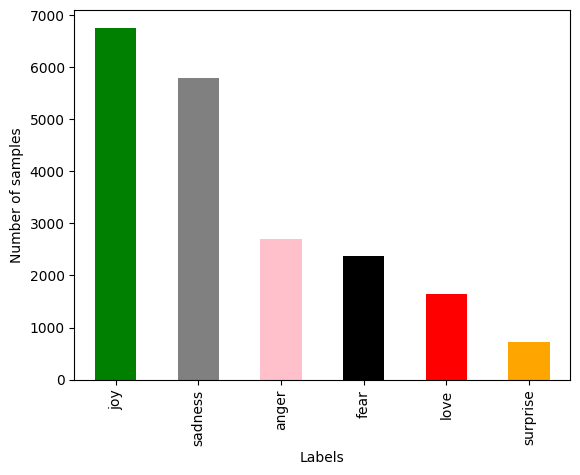

In [272]:
df["label"].value_counts().plot(
    kind="bar", color=["green", "gray", "pink", "black", "red", "orange"]
)
plt.xlabel("Labels")
plt.ylabel("Number of samples")
plt.show()

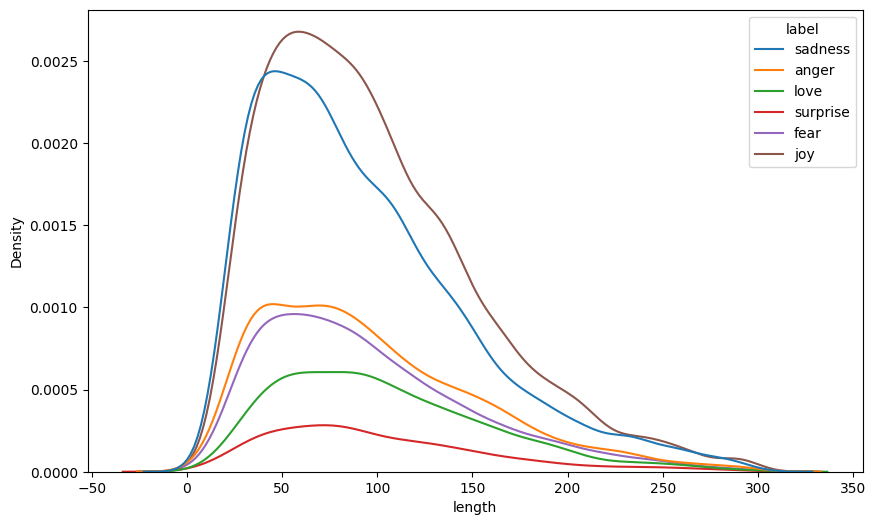

In [273]:
df["length"] = df.text.apply(lambda x: len(x))
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(x=df["length"], hue=df["label"])
plt.show()

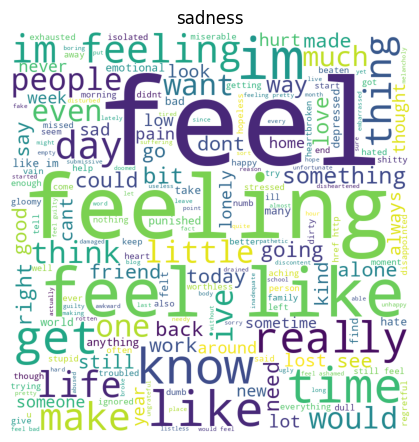

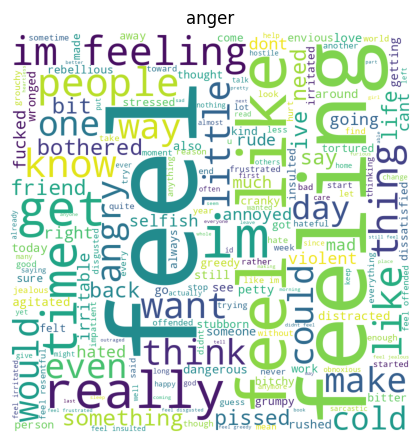

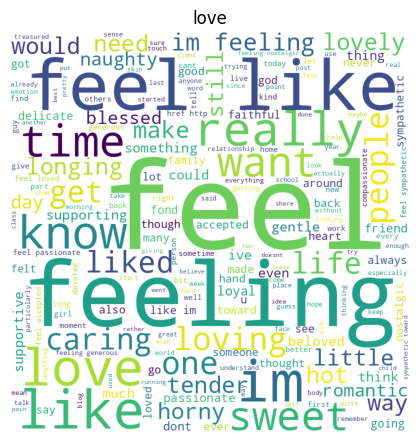

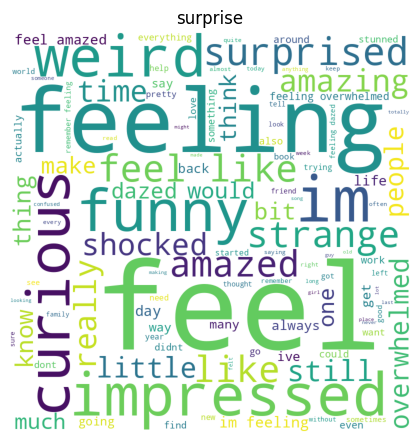

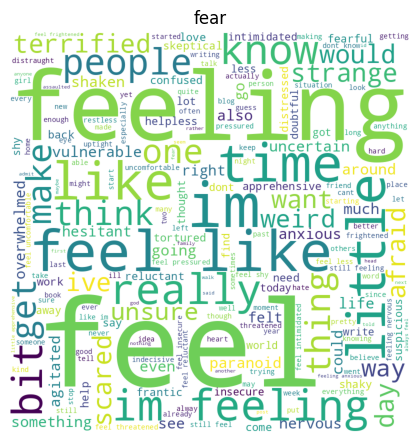

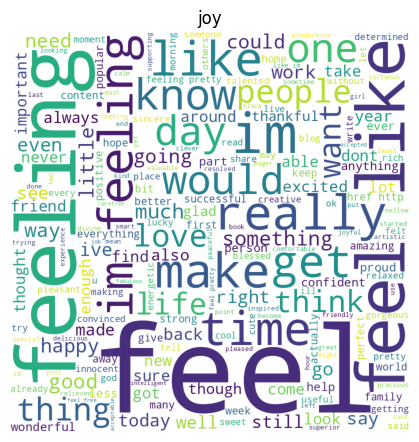

In [274]:
stopwords = set(nltk.corpus.stopwords.words("english"))
labels = df["label"].unique()
for label in labels:
    text = " ".join(df[df["label"] == label]["text"])
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
    ).generate(text)
    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(label)
    plt.show()

# Models


In [275]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=44
)

In [276]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

## Random Forest


In [277]:
rf = RandomForestClassifier(n_estimators=100, random_state=100)
rf.fit(X_train_cv, y_train)

RandomForestClassifier(random_state=100)

In [278]:
y_pred_rf = rf.predict(X_test_cv)

In [279]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification report of Random Forest classifier:\n", report_rf)

Classification report of Random Forest classifier:
               precision    recall  f1-score   support

       anger       0.90      0.83      0.87       495
        fear       0.85      0.79      0.82       454
         joy       0.84      0.94      0.89      1316
        love       0.88      0.73      0.80       353
     sadness       0.92      0.91      0.92      1241
    surprise       0.78      0.72      0.75       141

    accuracy                           0.88      4000
   macro avg       0.86      0.82      0.84      4000
weighted avg       0.88      0.88      0.87      4000



## Logistic Regression


In [280]:
lr = LogisticRegression(max_iter=1000, random_state=100)
lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=1000, random_state=100)

In [281]:
y_pred_lr = lr.predict(X_test_cv)

In [282]:
report_lr = classification_report(y_test, y_pred_lr)
print("Classification report of Logistic Regression (Multi-Class):\n", report_lr)

Classification report of Logistic Regression (Multi-Class):
               precision    recall  f1-score   support

       anger       0.90      0.87      0.88       495
        fear       0.87      0.80      0.84       454
         joy       0.89      0.94      0.91      1316
        love       0.82      0.78      0.80       353
     sadness       0.91      0.94      0.93      1241
    surprise       0.81      0.67      0.73       141

    accuracy                           0.89      4000
   macro avg       0.87      0.83      0.85      4000
weighted avg       0.89      0.89      0.89      4000



## Naive Bayes


In [283]:
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

MultinomialNB()

In [284]:
y_pred_nb = nb.predict(X_test_cv)

In [285]:
report_nb = classification_report(y_test, y_pred_nb)
print("Classification report of Multinomial Naive Bayes:\n", report_nb)

Classification report of Multinomial Naive Bayes:
               precision    recall  f1-score   support

       anger       0.92      0.63      0.75       495
        fear       0.87      0.49      0.63       454
         joy       0.71      0.95      0.81      1316
        love       0.93      0.23      0.36       353
     sadness       0.75      0.94      0.84      1241
    surprise       0.92      0.08      0.14       141

    accuracy                           0.76      4000
   macro avg       0.85      0.55      0.59      4000
weighted avg       0.79      0.76      0.73      4000



## SVM


In [286]:
svm = LinearSVC(random_state=100, max_iter=2000, dual=True)
svm.fit(X_train_cv, y_train)

LinearSVC(dual=True, max_iter=2000, random_state=100)

In [287]:
y_pred_svm = svm.predict(X_test_cv)

In [288]:
report_svm = classification_report(y_test, y_pred_svm)
print("Classification report of Linear SVM:\n", report_svm)

Classification report of Linear SVM:
               precision    recall  f1-score   support

       anger       0.89      0.87      0.88       495
        fear       0.85      0.80      0.82       454
         joy       0.90      0.92      0.91      1316
        love       0.77      0.79      0.78       353
     sadness       0.91      0.92      0.92      1241
    surprise       0.78      0.72      0.75       141

    accuracy                           0.88      4000
   macro avg       0.85      0.83      0.84      4000
weighted avg       0.88      0.88      0.88      4000



## LSTM


In [289]:
le = LabelEncoder()
y_train_lstm = le.fit_transform(y_train)
y_test_lstm = le.transform(y_test)

In [290]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [291]:
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [292]:
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=5000, output_dim=32))
model.add(LSTM(32))
model.add(Dense(len(labels), activation="softmax"))
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 62, 32)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,518 (658.27 KB)

 Trainable params: 168,518 (658.27 KB)

 Non-trainable params: 0 (0.00 B)

In [293]:
early_stop = EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(
    X_train_padded,
    y_train_lstm,
    epochs=25,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3357 - loss: 1.6012 - val_accuracy: 0.3344 - val_loss: 1.5740
Epoch 2/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3326 - loss: 1.5940 - val_accuracy: 0.3344 - val_loss: 1.5743
Epoch 3/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3452 - loss: 1.5773 - val_accuracy: 0.3344 - val_loss: 1.5750
Epoch 4/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3421 - loss: 1.5739 - val_accuracy: 0.3344 - val_loss: 1.5750


In [294]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_lstm, y_pred)
report = classification_report(
    y_test_lstm, y_pred, target_names=labels, zero_division=0
)
print("Accuracy:", accuracy)
print("Classification report of LSTM:\n", report)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.329
Classification report of LSTM:
               precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       495
       anger       0.00      0.00      0.00       454
        love       0.33      1.00      0.50      1316
    surprise       0.00      0.00      0.00       353
        fear       0.00      0.00      0.00      1241
         joy       0.00      0.00      0.00       141

    accuracy                           0.33      4000
   macro avg       0.05      0.17      0.08      4000
weighted avg       0.11      0.33      0.16      4000



## CNN


In [295]:
le = LabelEncoder()
y_train_cnn = le.fit_transform(y_train)
y_train_cnn = to_categorical(y_train_cnn)
y_test_cnn = le.transform(y_test)
y_test_cnn = to_categorical(y_test_cnn)

In [296]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [297]:
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [298]:
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=5000, output_dim=32))
model.add(Conv1D(64, 5, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(len(labels), activation="softmax"))

model.compile(
    optimizer="adamax",
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 62, 32)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 62, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,654 (701.77 KB)

 Trainable params: 179,526 (701.27 KB)

 Non-trainable params: 128 (512.00 B)

In [299]:
history = model.fit(X_train_padded, y_train_cnn, epochs=25, validation_split=0.2)

Epoch 1/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2952 - loss: 1.7432 - precision_6: 0.3122 - recall_6: 0.0578 - val_accuracy: 0.3525 - val_loss: 1.7132 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3478 - loss: 1.5740 - precision_6: 0.5090 - recall_6: 0.0218 - val_accuracy: 0.3875 - val_loss: 1.6005 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4056 - loss: 1.4963 - precision_6: 0.6201 - recall_6: 0.0790 - val_accuracy: 0.5178 - val_loss: 1.3955 - val_precision_6: 0.9518 - val_recall_6: 0.0741
Epoch 4/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5487 - loss: 1.2349 - precision_6: 0.7556 - recall_6: 0.3243 - val_accuracy: 0.6966 - val_loss: 1.0241 - val_precision_6: 0.9379 - val_recall_6: 0.3778
Epoch 5/25
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6968 - loss: 0.8541 - precision_6: 0.8429 - re

In [300]:
y_pred = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_cnn, axis=1)
accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(
    y_test_labels, y_pred_labels, target_names=labels, zero_division=0
)

print("Accuracy:", accuracy)
print("Classification report of CNN:\n", report)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9135
Classification report of CNN:
               precision    recall  f1-score   support

     sadness       0.92      0.91      0.91       495
       anger       0.91      0.83      0.87       454
        love       0.92      0.95      0.93      1316
    surprise       0.83      0.80      0.81       353
        fear       0.95      0.95      0.95      1241
         joy       0.76      0.82      0.79       141

    accuracy                           0.91      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.91      0.91      0.91      4000

